# The Project : Wrangle and Analyze Data (WeRateDogs)  


# Introduction

**This dataset that will be wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators almost always greater than 10. 11/10, 12/10, 13/10, Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.**

In [1]:
# import important libraries
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
% matplotlib inline

# turn off all warnings
import warnings
warnings.filterwarnings('ignore')

## Gathering the data  

**PART I: Enhanced Twitter Archive**  
> The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, the data have been filtered for tweets with ratings only (there are 2356).   

**PART II: Image Predictions Data**  
> A table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).  

**PART III: Additional Data via the Twitter API(tweets_json)**  
> Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. 

### PART I :

In [2]:
# read the 'weratedogs' file (PART I)
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

# quick view into data
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [3]:
# info about this part of data
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### PART II :

In [4]:
# create folder 'image_predictions'
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [5]:
# download 'image_predictions' data programmatically
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(image_predictions_url)
with open(os.path.join(folder_name ,
                           image_predictions_url.split('/')[-1]), mode = 'wb') as file:
        file.write(response.content)

# read the 'image_predictions' file
image_predictions = pd.read_csv('image-predictions.tsv' , sep='\t')

# quick view
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# info about this part of data
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### PART III :

In [7]:
# this part of code is not mine , it is from udacity.
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [8]:
# read 'tweet_json.txt' file
tweets_dics = []
with open('tweet_json.txt' , encoding = 'utf-8') as file:
    tweets_data = [json.loads(line) for line in file]
            
    # getting 'tweet_id' , 'retweet_count' and 'favorite_count'
    for tweet in tweets_data:
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
    
    # append to the list tweets_dics
        tweets_dics.append({'tweet_id' : str(tweet_id),
                            'retweet_count' : int(retweet_count),
                            'favorite_count' : int(favorite_count)})
    
    # create datafrme
    tweets_json = pd.DataFrame(tweets_dics, columns = ['tweet_id' , 'retweet_count' , 'favorite_count'])
    
# Quick view
tweets_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [9]:
# info about this part of data
tweets_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


## Assessing The Data  

**Here: we are going to find the Quality and Tidness issues for the three tables.**

In [10]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [11]:
# find out if there are duplicated tweet ids
sum(twitter_archive.tweet_id.duplicated())

0

In [12]:
# find out if all rating_denominator values equal 10 or not
sum(twitter_archive['rating_denominator'] != 10)

23

In [13]:
# find out if all rating_denominator values is valid
twitter_archive['rating_denominator'].sort_values()

313       0
2335      2
516       7
1576     10
1575     10
1574     10
1573     10
1572     10
1563     10
1570     10
1569     10
1568     10
1567     10
1566     10
1565     10
1564     10
1577     10
1571     10
0        10
1562     10
1547     10
1548     10
1549     10
1550     10
1551     10
1552     10
1553     10
1554     10
1555     10
1556     10
       ... 
782      10
781      10
775      10
799      10
780      10
779      10
776      10
777      10
778      10
800      10
784      11
1068     11
1662     11
342      15
1663     16
1165     20
1598     20
1433     40
1202     50
1351     50
1274     50
433      70
1843     80
1254     80
1228     90
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [14]:
# find out if all rating_numerator values is valid
twitter_archive['rating_numerator'].sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [15]:
# find out the sources used
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [16]:
# find out if there are meaningless names
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
the            8
Sadie          8
Daisy          7
an             7
Bailey         7
Buddy          7
Toby           7
Jax            6
Milo           6
Scout          6
Koda           6
Bella          6
Leo            6
Jack           6
Rusty          6
Oscar          6
Stanley        6
Dave           6
very           5
            ... 
Pumpkin        1
Pupcasso       1
Alejandro      1
Timber         1
Brutus         1
Tebow          1
Mollie         1
Brownie        1
Nida           1
Sonny          1
Mosby          1
Vinnie         1
Grizz          1
Fabio          1
Mutt           1
Zooey          1
Kody           1
Fillup         1
Ester          1
Kobe           1
Beya           1
Dook           1
Rinna          1
Jonah          1
Chloe          1
Tess           1
Holly          1
Jeffrie       

In [17]:
# statistics
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# data types
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [19]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [20]:
# data types
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
# find out if there are duplicated tweet ids
sum(image_predictions.tweet_id.duplicated())

0

In [22]:
# find out if there are values bigger than or equal 1 in column 'p1_conf'
sum(image_predictions.p1_conf >= 1)

1

In [23]:
# the only row with conf equal 1
image_predictions[image_predictions['p1_conf'] >=1].p1_conf

106    1.0
Name: p1_conf, dtype: float64

In [24]:
# find out if there are duplicated 'jpg_url'  (1)
sum(image_predictions.jpg_url.duplicated())

66

In [25]:
# find out if there are duplicated 'jpg_url'  (2)
image_predictions[image_predictions['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [26]:
# statistics
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
tweets_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [28]:
# data types
tweets_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [29]:
# find out if there are duplicated tweet ids
sum(tweets_json.tweet_id.duplicated())

0

In [30]:
# statistics
tweets_json.describe()

,retweet_count,favorite_count
count,2354.000000,2354.000000
mean,3164.797366,8080.968564
std,5284.770364,11814.771334
min,0.000000,0.000000
25%,624.500000,1415.000000
50%,1473.500000,3603.500000
75%,3652.000000,10122.250000
max,79515.000000,132810.000000


### The Issues:  

#### Quality:  
**`twitter_archive` Table.**  

- **The original tweets all we need**(retweets not)
- **'NaN' instead of 'None' in some columns**(which make columns have null values)
- **meaningless names** in 'name' coumn like(a , an , bo , the)
- **Erroneous datatypes**, columns( tweet_id , in_reply_to_status_id , in_reply_to_user_id , retweeted_status_id , retweeted_status_user_id , timestamp , retweeted_status_timestamp )
- **Unnecessary words in source column**
- **There are some invalid  values in 'rating_numerator' and 'rating_denominator' columns**
<br><br>

**`image_predictions` Table.**  

- **Erroneous datatypes** , 'tweet_id' column 
- **duplicated jpg_urls for different tweet ids**(66 urls)
- **In column 'p1_conf' we have one value of 1** (this issue is not a big one but in our lifes it is impossible for confident percentage to equal 1)
<br><br>




#### Tidiness:  


- **one variable in four columns (breeds variable) in `twitter_archive` table**
- **`tweets_json` table and `image_predictions` should be part of `twitter_archive` table**(merge all datas into one datafrme)
- **there are columns which we will not be used in analying** like(retweeted_status_id  ,  retweeted_status_user_id  ,  retweeted_status_timestamp )


## Cleaning The Data

In [31]:
# creating copies of datas to do cleaning operation
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweets_json_clean = tweets_json.copy()

#### Issue 1: one variable in four columns (breed variable) in `twitter_archive_clean` Table

##### Define:  
- Convert the four columns ( doggo , floofer , pupper , puppo ) into one column called (breed) using melt function

##### Code:

In [32]:
# creating lists of columns
columns = twitter_archive_clean.columns
melt_columns = ['doggo' , 'floofer' , 'pupper' , 'puppo']
reset_columns = [x for x in columns if x not in melt_columns]

# melt the four columns into one column(breed)
twitter_archive_clean = pd.melt(twitter_archive_clean , id_vars = reset_columns , value_vars = melt_columns,
                               value_name = 'breed')

# sort values of column 'breed' to drop duplicated rows (which make all none values in the top to be droped first and keep the last)
twitter_archive_clean = twitter_archive_clean.sort_values('breed')

# drop the column 'variable' and duplicted rows resulting from the melting operation
twitter_archive_clean = twitter_archive_clean.drop('variable' , axis = 1)
twitter_archive_clean = twitter_archive_clean.drop_duplicates(subset = 'tweet_id', keep = 'last')

##### Test:

In [33]:
# test
twitter_archive_clean.breed.value_counts()

None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: breed, dtype: int64

#### Issue 2: Unnecessary words in source column

##### Define:
- extract url from the string in source column in `twitter_archive_clean` table

##### Code:

In [34]:
# extract url from the string in source column
twitter_archive_clean.source = twitter_archive_clean.source.str.extract('(http\D+"\s)').str.extract('(http\D+\w)')

##### Test:

In [35]:
# test
twitter_archive_clean.source.value_counts()

http://twitter.com/download/iphone              2221
http://vine.co                                    91
http://twitter.com                                33
https://about.twitter.com/products/tweetdeck      11
Name: source, dtype: int64

#### Issue 3: **meaningless names** in 'name' coumn like(a , an , bo , the)

##### Define:
- convert the meaningless names to none
- convert all names whose lengths equal or smaller than 3 to 'None'

##### Code:

In [36]:
# convert all names whose lengths equal or smaller than 3
twitter_archive_clean['name_len'] = twitter_archive_clean['name'].apply(len)
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['name_len'] > 3]
twitter_archive_clean = twitter_archive_clean.drop('name_len' , axis = 1)

##### Test:

In [37]:
# test
twitter_archive_clean.name.value_counts()

None            745
Charlie          12
Oliver           11
Cooper           11
Lucy             11
Penny            10
Tucker           10
Lola             10
Winston           9
Sadie             8
Buddy             7
Toby              7
Bailey            7
Daisy             7
Jack              6
Koda              6
Bella             6
Stanley           6
Scout             6
Rusty             6
Dave              6
Oscar             6
Milo              6
Sunny             5
Oakley            5
Larry             5
Phil              5
Finn              5
Bentley           5
Chester           5
               ... 
Banjo             1
Humphrey          1
unacceptable      1
Boston            1
Wiggles           1
Dudley            1
Kirk              1
Kara              1
Chase             1
Skye              1
Shikha            1
Pavlov            1
Kuyu              1
Anthony           1
Marvin            1
incredibly        1
Lance             1
Tanner            1
Yukon             1


#### Issue 4:The original tweets all we need(retweets not)  in `twitter_archive_clean` table

##### Define:  
- Remove retweets by removing the rows which have a value in column 'retweeted_status_id'

##### Code:

In [38]:
# Remove retweets by removing the rows which have a value in column 'retweeted_status_id' (keep NaN)
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

##### Test:

In [39]:
# test
twitter_archive_clean.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

#### Issue 5: There are some invalid  values in 'rating_numerator' and 'rating_denominator' columns 

##### Define :

- corect ratings in columns rating_numerator and rating_denominator

##### Code :

##### Step 1: Manually 

In [40]:
# to see all text in the column ...we wil make the column width bigger
pd.options.display.max_colwidth = 200

# finding the values of rating_denominator which don't equal 10 (almost all rating_denominator equal 10)
twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
3789,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3954,686035780142297088,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",4,20
3990,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130
3991,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
3521,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
3558,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
3424,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
3476,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
3584,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3630,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


In [41]:
# to see all text in the column ...we wil make the column width bigger
pd.options.display.max_colwidth = 200

# finding the values of rating_numerator which equal or bigger than 20 (make rating_denominator maximum be 10)
twitter_archive_clean[twitter_archive_clean['rating_numerator'] >= 20][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
3789,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3990,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130
3991,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
3558,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
3476,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
3584,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3630,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
3610,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
4430,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10
4068,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


> **as we could see from the results above that there are some values need to be corrected and some wil be deleted**  <br>
**there is no other way,we have to correct it manually**  <br>
**we will drop rows with index (342,2335,516,1663,695)**  
**we will keep the rest to be corrected programtically**

In [42]:
# convert 'rating_numerator' type to float because there are floats in the values
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype(float)

# create function to correct
def correct_rating(tweet_id,correct_numerator,correct_denominator):
    """
    function to correct the ratings manually
    parmeters: tweet_id,correct_numerator,correct_denominator
    return the data with corrected ratings
    """
    twitter_archive_clean['rating_numerator'][twitter_archive_clean['tweet_id'] == tweet_id] = correct_numerator
    twitter_archive_clean['rating_denominator'][twitter_archive_clean['tweet_id'] == tweet_id] = correct_denominator

# correct
correct_rating(835246439529840640,13,10)
correct_rating(775096608509886464,14,10)
correct_rating(740373189193256964,14,10)
correct_rating(722974582966214656,13,10)
correct_rating(716439118184652801,11,10)
correct_rating(682962037429899265,10,10)
correct_rating(666287406224695296,9,10)
correct_rating(832215909146226688,9.75,10)
correct_rating(778027034220126208,11.27,10)
correct_rating(680494726643068929,11.26,10)


# drop the rows with no rating on it
drop_tweet_id = [832088576586297345 , 810984652412424192 , 682808988178739200 , 786709082849828864]
for tweet_id in drop_tweet_id:
    twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != tweet_id]

##### Step 2:  programmatically

> **Now there are many ratings in this data unreasonable and to correct them programmatically , we wil make rating_denominator always equal to 10 and then we will calculate the ratio of rating_numerator to rating_denominator(we will make rating_numerator maximum value is 20 which makes maximum ratio is 2)...we will drop all rows with ratio bigger than 2 and smaller than 1...and then multiply the ratio by ten to get rating_numerator corrected**

In [43]:
# create 'rating' column
twitter_archive_clean['ratio'] = twitter_archive_clean.rating_numerator / twitter_archive_clean.rating_denominator

# drop all rows with rating bigger than 2 and smaller than 1
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['ratio'] <= 2]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['ratio'] >= 1]

# make all values of 'rating_denominator' equal 10
twitter_archive_clean['rating_denominator'] = 10

# coorect 'rating_numerator' values by multiply the ratio by 10
twitter_archive_clean['rating_numerator'] = twitter_archive_clean.ratio *10

# drop column 'ratio'
twitter_archive_clean = twitter_archive_clean.drop('ratio' , axis = 1)

##### Test :

In [44]:
# test on 'rating_denominator' values
len(twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 10])

0

In [45]:
# test on 'rating_numerator' values
len(twitter_archive_clean[twitter_archive_clean['rating_numerator'] >= 20])

0

#### Issue 6: duplicated jpg_urls for different tweet ids(66 urls)  (`image_predictions_clean` table)
#### Issue 7: In column 'p1_conf' we have one value of 1 (this issue is not a big one but in our lifes it is impossible for confident   percentage to equal 1)(`image_predictions_clean` table)  

##### Define:  
- drop rows with duplicated jpg_urls from `image_predictions_clean` table
- drop the only row with p1_conf equal 1 from `image_predictions_clean` table

##### Code:

In [46]:
# drop rows with duplicated jpg_urls
image_predictions_clean = image_predictions_clean.drop_duplicates(subset='jpg_url')

# drop the only row with p1_conf equal 1
image_predictions_clean = image_predictions_clean[image_predictions_clean['p1_conf'] != 1]

##### Test:

In [47]:
# test for issue 6
sum(image_predictions_clean.jpg_url.duplicated())

0

In [48]:
# test for issue 7
image_predictions_clean[image_predictions_clean['p1_conf'] == 1]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Issue 8: Erroneous datatypes  in `image_predictions_clean` and `twitter_archive_clean` tables (tweet_id)

##### Define:  
- convert    tweet_id    from int to str in both tables `image_predictions_clean` and `twitter_archive_clean` for merging with the third table


##### Code:

In [49]:
# converting tweet_id from int to str in twitter_archive_clean
twitter_archive_clean['tweet_id'] = twitter_archive_clean.tweet_id.astype(str)

# converting tweet_id from int to str in image_predictions_clean
image_predictions_clean['tweet_id'] = image_predictions_clean.tweet_id.astype(str)

##### Test:

In [50]:
# test
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2008 non-null object
jpg_url     2008 non-null object
img_num     2008 non-null int64
p1          2008 non-null object
p1_conf     2008 non-null float64
p1_dog      2008 non-null bool
p2          2008 non-null object
p2_conf     2008 non-null float64
p2_dog      2008 non-null bool
p3          2008 non-null object
p3_conf     2008 non-null float64
p3_dog      2008 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


In [51]:
# Test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616 entries, 2263 to 7236
Data columns (total 14 columns):
tweet_id                      1616 non-null object
in_reply_to_status_id         61 non-null float64
in_reply_to_user_id           61 non-null float64
timestamp                     1616 non-null object
source                        1616 non-null object
text                          1616 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1573 non-null object
rating_numerator              1616 non-null float64
rating_denominator            1616 non-null int64
name                          1616 non-null object
breed                         1616 non-null object
dtypes: float64(5), int64(1), object(8)
memory usage: 189.4+ KB


#### Issue 9: `tweets_json` table and `image_predictions` should be part of `twitter_archive` table(merge all datas into one datafrme)

##### Define:
- merge all datas on tweet_id

##### code:

In [52]:
# merge 'twitter_archive_clean' with 'image_predictions_clean'
twitter_archive_clean = pd.merge(twitter_archive_clean , image_predictions_clean , on = 'tweet_id' , how = 'inner')

# merge 'twitter_archive_clean'(the result from the previous code) with 'tweets_json_clean'
twitter_archive_all_data = pd.merge(twitter_archive_clean , tweets_json , on = 'tweet_id' , how = 'inner')

##### Test:

In [53]:
# test
twitter_archive_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 27 columns):
tweet_id                      1461 non-null object
in_reply_to_status_id         21 non-null float64
in_reply_to_user_id           21 non-null float64
timestamp                     1461 non-null object
source                        1461 non-null object
text                          1461 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1461 non-null object
rating_numerator              1461 non-null float64
rating_denominator            1461 non-null int64
name                          1461 non-null object
breed                         1461 non-null object
jpg_url                       1461 non-null object
img_num                       1461 non-null int64
p1                            1461 non-null object
p1_conf                       1461 n

#### Issue 10: there are columns which we will not be used in analying like(retweeted_status_id  ,  retweeted_status_user_id  ,  retweeted_status_timestamp )

##### Define:
- drop unnecessary columns that will not be used in analyzing

##### Code:

In [54]:
# drop unnecessary columns
drop_columns = ['retweeted_status_id' , 'retweeted_status_user_id' , 'retweeted_status_timestamp' ,
                'in_reply_to_status_id' , 'in_reply_to_user_id'] 
    # as we no longer care about retweets and (in_reply_to_status_id , in_reply_to_user_id) don't have enough values(useless)

twitter_archive_all_data = twitter_archive_all_data.drop(drop_columns , axis = 1)

##### Test:

In [55]:
# test
twitter_archive_all_data.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'breed', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

#### Issue 11: Erroneous datatypes  in `twitter_archive_clean` table (timestamp)

##### Define:  

- convert    timestamp      from str to datetime


#### Code:

In [56]:
# convert timestamp  from str to datetime
twitter_archive_all_data['timestamp'] = pd.to_datetime(twitter_archive_all_data.timestamp)

##### Test:

In [57]:
# test
twitter_archive_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 22 columns):
tweet_id              1461 non-null object
timestamp             1461 non-null datetime64[ns]
source                1461 non-null object
text                  1461 non-null object
expanded_urls         1461 non-null object
rating_numerator      1461 non-null float64
rating_denominator    1461 non-null int64
name                  1461 non-null object
breed                 1461 non-null object
jpg_url               1461 non-null object
img_num               1461 non-null int64
p1                    1461 non-null object
p1_conf               1461 non-null float64
p1_dog                1461 non-null bool
p2                    1461 non-null object
p2_conf               1461 non-null float64
p2_dog                1461 non-null bool
p3                    1461 non-null object
p3_conf               1461 non-null float64
p3_dog                1461 non-null bool
retweet_count         1461 no

#### Issue 12: 'NaN' instead of 'None' in some columns

##### Define:  
- Converte '' value to '' in some columns of `twitter_archive` using replace function
- 'NaN' values was in drop_columns which was dropped in the previous steps which means this issue is no longer existed

In [58]:
# test that there are no nans in dataframe
twitter_archive_all_data.isnull().values.any()

False

## Storing The Data

In [59]:
# storing 'twitter_archive_all_data' to a file 'twitter_archive_master'
twitter_archive_all_data.to_csv('twitter_archive_master.csv' , encoding = 'utf-8' , index = False)

## Analyzing and visualizing The Data  
> ##### Analyzing Report will be in a seperate file outside this jupyter notebook in a pdf file called 'act_report.pdf'

In [60]:
# read the new file
df_dogs = pd.read_csv('twitter_archive_master.csv')

# quick view
df_dogs.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,breed,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,667544320556335104,2015-11-20 03:25:43,http://twitter.com,"This is Kial. Kial is either wearing a cape, which would be rad, or flashing us, which would be rude. 10/10 or 4/10 https://t.co/8zcwIoiuqR",https://twitter.com/dog_rates/status/667544320556335104/photo/1,10.0,10,Kial,None,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,...,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,568,917
1,667524857454854144,2015-11-20 02:08:22,http://twitter.com,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,https://twitter.com/dog_rates/status/667524857454854144/photo/1,12.0,10,None,None,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,...,0.447893,False,dhole,0.092435,False,Chesapeake_Bay_retriever,0.088122,True,1198,1798
2,667509364010450944,2015-11-20 01:06:48,http://twitter.com,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,https://twitter.com/dog_rates/status/667509364010450944/photo/1,12.0,10,None,None,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,...,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True,2272,7148


### Insight 1:The most popular dog breed

In [61]:
# higher favorite_count
df_dogs.groupby('breed').favorite_count.mean().sort_values(ascending = False)

breed
puppo      23607.863636
doggo      18965.982456
floofer    15179.833333
None       10236.210526
pupper      7907.793750
Name: favorite_count, dtype: float64

In [62]:
# higher retweet_count
df_dogs.groupby('breed').retweet_count.mean().sort_values(ascending = False)

breed
puppo      7313.954545
doggo      6889.526316
floofer    5406.666667
None       3071.847862
pupper     2633.343750
Name: retweet_count, dtype: float64

In [63]:
# higher rating_numerator
df_dogs.groupby('breed').rating_numerator.mean().sort_values(ascending = False)

breed
puppo      12.181818
doggo      12.052632
floofer    11.833333
None       11.411398
pupper     11.270437
Name: rating_numerator, dtype: float64

### Insight 2: Dog type with highest rating

In [64]:
# perecentge of true predictions in p_1 column of the data
df_dogs[df_dogs['p1_dog'] == True].shape[0] * 100 / df_dogs.shape[0]

79.53456536618754

In [65]:
# perecentge of true predictions in p_2 column of the data
df_dogs[df_dogs['p1_dog'] == False][df_dogs['p2_dog'] == True].shape[0] * 100 / df_dogs.shape[0]

6.913073237508556

In [66]:
# perecentge of true predictions in p_3 column of the data
df_dogs[df_dogs['p1_dog'] == False][df_dogs['p2_dog'] == False][df_dogs['p3_dog'] == True].shape[0] * 100 / df_dogs.shape[0]

2.8062970568104038

> **From previous percentages , we could tell that prediction 1 have most of the True predictions in the data so we will make our analysis on it and ignore the other predictions for this insight.**

In [67]:
# the highest rating (only depended on rating_numerator)(as rating_denumerator = 10 for all rating)
df_dogs[df_dogs['p1_dog'] == True].groupby('p1').rating_numerator.mean().sort_values(ascending = False).head()

p1
black-and-tan_coonhound    14.0
Bedlington_terrier         13.5
Afghan_hound               13.0
curly-coated_retriever     13.0
Saluki                     12.5
Name: rating_numerator, dtype: float64

### Insight 3 & visualization 1: Dog type with the biggest number of ratings & Retweets Count & favorite Count

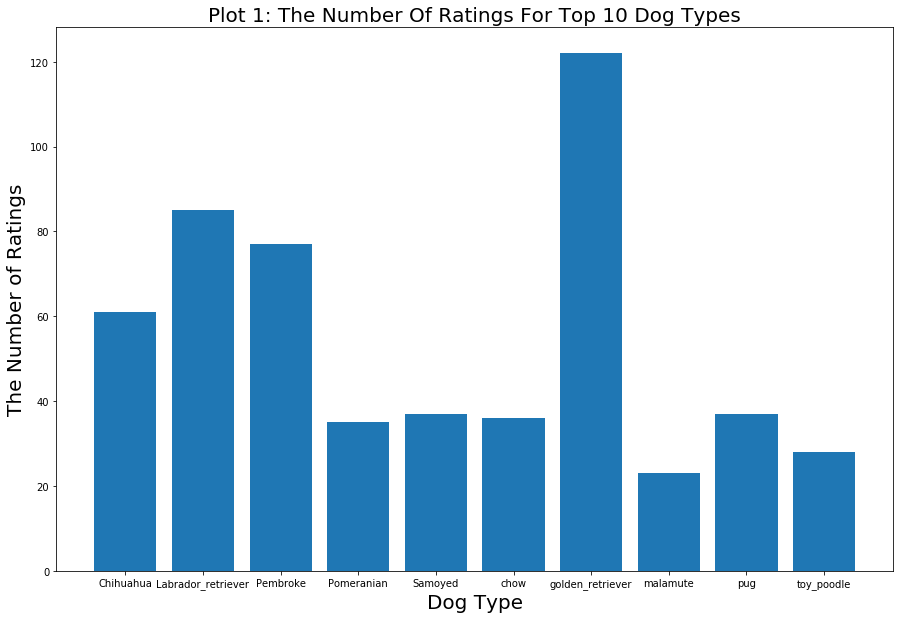

In [68]:
# to make the plot bigger
plt.figure(figsize=(15,10))

# finding 10 dog_type with highest number of ratings
dogs_types_n = df_dogs[df_dogs['p1_dog'] == True].groupby('p1').rating_numerator.count().sort_values(ascending = False).head(10)

# plot the number of ratings
plt.bar(dogs_types_n.index , height = dogs_types_n)

# title and labels
plt.title('Plot 1: The Number Of Ratings For Top 10 Dog Types' , fontsize = 20)
plt.xlabel('Dog Type' , fontsize = 20)
plt.ylabel('The Number of Ratings' , fontsize = 20)

plt.show;

> **we are going to visualize the retweet count and favourite count for 10 dogs types (the higher count)**

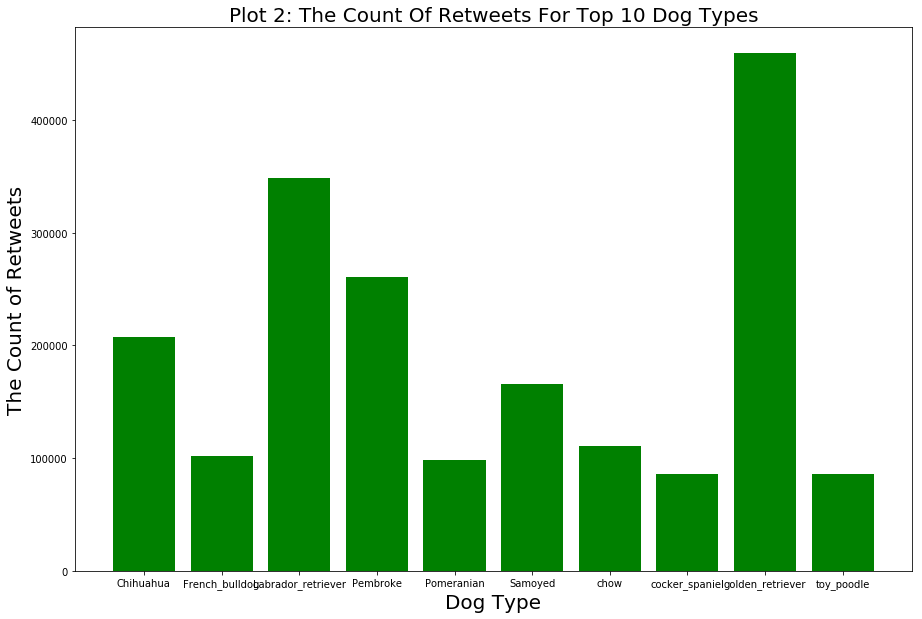

In [69]:
# to make the plot bigger
plt.figure(figsize=(15,10))

# finding 10 dog_type with highest count of retweets
dogs_types_retweet = df_dogs[df_dogs['p1_dog'] == True].groupby('p1').retweet_count.sum().sort_values(ascending = False).head(10)

# plot the count of retweet
plt.bar(dogs_types_retweet.index , height = dogs_types_retweet , color = 'green')

# title and labels
plt.title('Plot 2: The Count Of Retweets For Top 10 Dog Types' , fontsize = 20)
plt.xlabel('Dog Type' , fontsize = 20)
plt.ylabel('The Count of Retweets' , fontsize = 20)

plt.show;

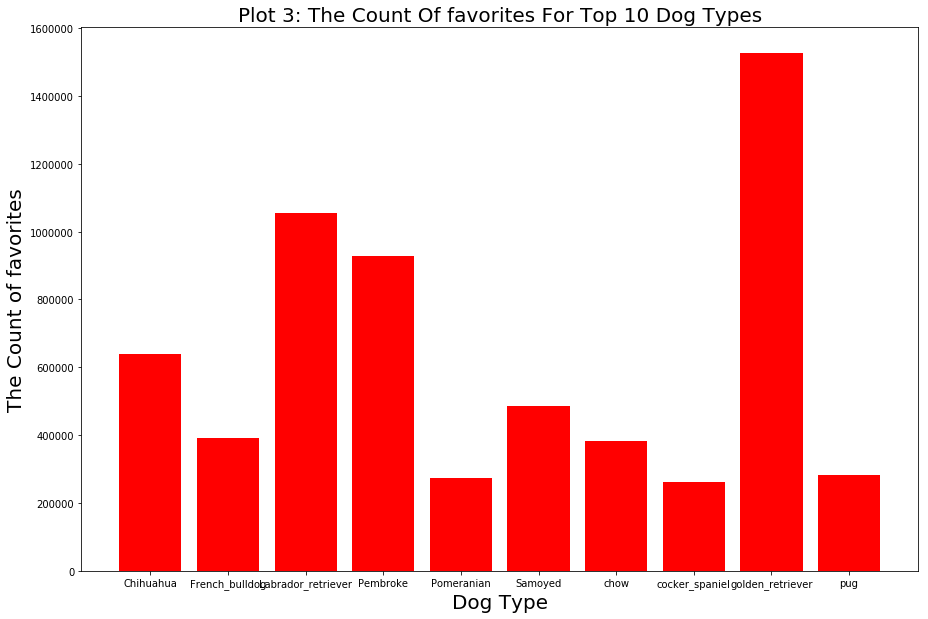

In [70]:
# to make the plot bigger
plt.figure(figsize=(15,10))

# finding 10 dog_type with highest count of favorite
dogs_types_favorite = df_dogs[df_dogs['p1_dog'] == True].groupby('p1').favorite_count.sum().sort_values(ascending = False).head(10)

# plot the count of favorites
plt.bar(dogs_types_favorite.index , height = dogs_types_favorite , color = 'red')

# title and labels
plt.title('Plot 3: The Count Of favorites For Top 10 Dog Types' , fontsize = 20)
plt.xlabel('Dog Type' , fontsize = 20)
plt.ylabel('The Count of favorites' , fontsize = 20)

plt.show;

### Insight 4: The Best Dog Types

In [71]:
# calculating the means of 'rating_numerator' , 'retweet_count' and 'favorite_count'
dog_type_rating_mean = df_dogs[df_dogs['p1_dog'] == True].rating_numerator.mean()
dog_type_retweet_mean = int(df_dogs[df_dogs['p1_dog'] == True].retweet_count.mean())
dog_type_favorite_mean = int(df_dogs[df_dogs['p1_dog'] == True].favorite_count.mean())

# The best dog types (we multiply the means by 10 to reduce the results to the best of the best)
best_dogs = df_dogs[df_dogs['p1_dog'] == True][df_dogs['rating_numerator'] >= dog_type_rating_mean]
best_dogs = df_dogs[df_dogs['p1_dog'] == True][df_dogs['retweet_count'] >= 10 * dog_type_retweet_mean]
best_dogs = df_dogs[df_dogs['p1_dog'] == True][df_dogs['favorite_count'] >= 10 * dog_type_favorite_mean]

# create a column to sum 'favorite_count' and 'retweet_count'
best_dogs['sum_retweet_favorite'] = best_dogs['favorite_count'] + best_dogs['retweet_count']

# group the data by 'p1' and sort the values of column by 'sum_retweet_favorite'
best_dogs = best_dogs[['p1','rating_numerator','retweet_count','favorite_count','sum_retweet_favorite']]
best_dogs.groupby('p1').mean().sort_values(by = 'sum_retweet_favorite' , ascending = False)

,rating_numerator,retweet_count,favorite_count,sum_retweet_favorite
p1,,,,
Labrador_retriever,13.0,79515,131075,210590
Lakeland_terrier,13.0,48265,132810,181075
Chihuahua,13.0,56625,107015,163640
English_springer,13.0,45849,107956,153805
French_bulldog,13.0,32883,106827,139710


> ##### Analyzing Report will be in a seperate file outside this jupyter notebook in a pdf file called 'act_report.pdf'